In [1]:
#XSPEDS Algorithm
#20/03/2025
#B803 

'''
Combines single-phton counting with bragg mapping to produce spectral lineouts:
Data cleaning and SPC
Bragg mapping
Spectral Lineout
SNR and FWHM calculation

Libraries:
  numpy
  scipy (ndimage, optimize, signal,wiener)
  collections (deque)
  pybaselines
  matplotlib
  h5py



Run this in order. The variable have already been entered but can be modified. The code takes around 5 mins to run in total, but it depends on some of the input paramters
 E.g. for out energy step for the spectral lineout, if you set it to 0.1 eV, it will take around 3 minutes than if you set it to 1'''

# This cell preprocesses the CCD data and forms the first part of the SPC algorithm



import numpy as np
import h5py
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution, least_squares

from pybaselines import morphological
import pandas as pd
from scipy.ndimage import gaussian_filter1d




from collections import deque

from scipy.signal import wiener

#Get h5 image data from experiment
f_name = 'sxro6416-r0504.h5'
datafile = h5py.File(f_name, 'r')
image_data = []
for i in itertools.count(start=0):
    d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
    if d is not None:
        #the first 3 columns seem to have an unecesary spike, skewing the data. 
        #Since this only makes up 3/2000 of the columns, it's rather safe to remove this
        image_data.append(d[0][:, 3:]) 
    else:
        break

#Split up the numpy array into batches of 5 rows, 
# as we found that sum of values across the rows aren;t uniform, 
# contrary to expectations.

def scotts_rule(batch):
                '''Just gets the binning for the histogram, based on the stdev of the data. FOr our data, it is almost always 1'''
                std_dev = np.std(batch)
                bin_w = max(3.5*std_dev/(len(batch)**(1/3)), 1)
                bins = int((batch.max()-batch.min())/bin_w)
                #nb we need to make sure the min binning is 1
                return max(bins, 1), bin_w
def scrubbing(image_data, size_rows,lower_bound, upper_bound):
    '''Finds gaussian paramters it fits in the pedestal
    Also dynamically thresholds based off the gaussian fit fro each row batch. Returns thresholded matrices.'''
    gauss_row_dict = {}
    #Will loop over images, and then rows batches fo 5
    t=0
    scrubbed_image_new = []
    for i in image_data:
        scrubbed_image=i.copy()
        #print('here')
        for j in range(0, i.shape[0], size_rows):
            #print('hi')

            
            # #the min stops it form going beyind the bounds of the image
            # j_end = min(j + size_rows, i.shape[0])

            #create the histogram to plot the ADU values
            batch= i[j:j + size_rows-1].ravel()   

            #fit the gaussian        
            def gaussian_eqn(x, Amp, mu, stdev):
                return np.exp(-((x-mu)**2)/(2*stdev**2))*Amp
            
            #Now especially for small batch sizings, we need to be carefulm of binning, and keep it consistent for when findnin g the threshsold
            #There's smth called Scott's rule which finds the optimum bin size, based on the stdev of the data
            
            
            
            bin_c, bin_w= scotts_rule(batch)
            counts, bin_edges = np.histogram(batch, bins=bin_c)
            centre_bin=0.5*(bin_edges[1:] + bin_edges[:-1])

            p,cov= curve_fit(gaussian_eqn, centre_bin, counts, p0=[1, np.mean(batch), np.std(batch)])
            Amp,mu,stdev=p
            stdev=abs(stdev)  #the code sometimes spits out stdev as negative fsr

            error=np.sqrt(np.diag(cov))

            A_err, mu_err, stdev_err = error


            

            
            #Finding the threshold, as in the paper

            def gaussian(x):
                return Amp*np.exp(-((x-mu)**2)/(2*stdev**2))
            predicted = gaussian(centre_bin)
            lower_limit = mu+lower_bound*stdev
            upper_limit = mu+upper_bound*stdev

            mask= (centre_bin >= lower_limit) & (centre_bin <= upper_limit)
            allowed_centers = centre_bin[mask]
            allowed_counts = counts[mask]
            allowed_predicted = predicted[mask]


            #Find the allowed bin where the observed count is closest to twice the predicted count
            
            differences = np.abs(counts[mask] - 2 * predicted[mask])
            


            local_bin = np.argmin(differences)
            actual_bin = np.where(mask)[0][local_bin]

            threshold = centre_bin[actual_bin]

            #this stdev is kinda redundant, but was used for analysis
            stdev_thresh=(threshold-mu)/stdev
            



            #Now to create the scrubbed images
            
            
            batch_slice = slice(j, j+size_rows)
            #print(batch_slice)
            #print(scrubbed_image[batch_slice])
            scrubbed_image[batch_slice] = np.where(scrubbed_image[batch_slice] < threshold,
                                                0,
                                                scrubbed_image[batch_slice])
        scrubbed_image_new.append(scrubbed_image) 

            #dictionary can be used for data analysis as in paper.
            # gauss_row_dict[(t, j, j+size_rows)]={'start_row': j,'end_row':j+size_rows, 'amplitude': Amp,
            #     'mean': mu,
            #     'stdev':stdev,
            #     'bin_width': bin_w,
            #     'amplitude_uncertainty': A_err,
            #     'mean_uncertainty': mu_err,
            #     'stddev_uncertainty':stdev_err,
            #     'data': batch,
            #     'threshold': threshold,
            #     'std_thresh': stdev_thresh} 





        t+=1

    return scrubbed_image_new
            


size_rows=5
#get dictionary of gaussian fits per row batch.

#See paper about the threshold
#This just sets the bounds for what we look over to find the threshold, otherwise it would return a threshold too large when the excess=inner=0
#So we assume that there are values between 1stdev and 5stdev.
lower_bound=1
upper_bound=5
new_image_scrubbed=scrubbing(image_data, size_rows,lower_bound, upper_bound)

# Finding threshold, dynamic, see paper


#now we need to find the optimum threshold. This could've been put in the above funciton, but it's getting messy and it's easier to debug by splitting it up
#we need to iterate over the rows again.








In [2]:
#Main part of SPC, identifies the clusters and reconstructs the CCD matrix into 1s and 0s (with 2s for 'other' shape clusters)
#Now we're going to convert the numpy array into binary 1s and 0s for photons


photon_map=[]


def cluster_detecting(image):
    '''Identifies the clusters in specific shapes, and returns a dictionary with the cluster number as key and the coordinates of the cluster as value.
    Also returns a photon map, which is a binary matrix with 1s for photons and 0s for background (and 2 for odd shapes).'''
    SINGLE = [{(0,0)}]
    LINE_TWO = [{(0,0), (0,1)},  {(0,0), (1,0)} ]

    LINE_THREE=[{(0,0), (0,1), (0,2)}, {(0,0), (1,0), (2,0)}]
    L_SHAPE=[{(0,0), (1,0), (1,1)},{(0,1), (1,1), (1,0)},{(0,0), (0,1), (1,0)},{(0,0), (0,1), (1,1)}]

    BOX=[{(0,0), (0,1), (1,0), (1,1)}]

    visiting_tracker=np.zeros_like(image, dtype=bool)

    no_rows, no_cols = image.shape

    #generator to be memory efficient
    #just gets valid non-0 neighbours
    def find_adjacent(r, c):
        for next_r, next_col in [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]:
            if 0 <= next_r < no_rows and 0 <= next_col < no_cols:
                yield next_r, next_col


    #FIX THIS
    def identify_shape(coords_set):

        #this minning makes it independent of the position of the cluster in the image  
        min_r = min(r for r, c in coords_set)
        min_c = min(c for r, c in coords_set)
        normalized = set((r - min_r, c - min_c) for (r, c) in coords_set)
        

        size = len(normalized)
        if size==1:
            if normalized in SINGLE:
                return 'single'
            
        elif size==2:
            if normalized in LINE_TWO:
                return 'line2'
            
        elif size==3:
            if normalized in LINE_THREE:
                 return 'line3'
            if normalized in L_SHAPE:
                return 'lshape3'
            
        elif size==4:
            if normalized in BOX:
                return 'box4'
            
        else:
            return 'other'
        

    
    clusters_dict = {}

    #will iterate through the cluster numbers and add 1 as it identifies the clusters
    cluster_no=0


    for i in range(no_rows):
        for j in range(no_cols):

            #ignore background
            if image[i, j] == 0:
                continue

            #next strategy is to a queue for each cluster, the deque part is used bc it's a rather large matrix and optimisation is little bit important
            if not visiting_tracker[i,j]:
                cluster_no += 1
                queue = deque([(i,j)])
                visiting_tracker[i,j] = True
                location = []
                
                while queue:
                    ii, jj = queue.popleft()
                    location.append((ii,jj))
                    
                    for testrow, testcol in find_adjacent(ii, jj):
                        if not visiting_tracker[testrow, testcol] and image[testrow, testcol] != 0:
                            visiting_tracker[testrow, testcol] = True

                            #add to the pixel queue in the cluster
                            queue.append((testrow, testcol))
                
                #easy fix to remove the dupes, probably should've done smth more sophisticated above
                coords=set(location)


                shape=identify_shape(coords)
                pixel_values = [image[test_row, test_col] for (test_row, test_col) in coords]

                #needed later to use as photon centroid
                max_val = max(pixel_values)
                sum_val = sum(pixel_values)
                max_coord = max(coords, key=lambda coord:image[coord])


                clusters_dict[cluster_no]={'coords': coords,
                    'shape': shape,
                    'max_value': max_val,
                    'values': pixel_values,
                    'sum': sum_val,
                    'centroid': max_coord}



    #now recreating the photon map

    matrix_size = image.shape
    centroid_array = np.zeros(matrix_size, dtype=int)
    
    #Iterating over the cluster info
    for cluster in clusters_dict.values():
        #other clusters are counted as 2 photons,as stated in the paper


        if cluster['shape'] != 'other':
            r, c = cluster['centroid']
            
            if 0 <= r < matrix_size[0] and 0 <= c < matrix_size[1]:
                centroid_array[r, c] = 1
        elif cluster['shape'] == 'other' and cluster['max_value'] > 90:
            r, c = cluster['centroid']
            
            if 0 <= r < matrix_size[0] and 0 <= c < matrix_size[1]:
                centroid_array[r, c] = 2
    
    return clusters_dict, centroid_array









#loop through the images
photon_map_all=[]
photon_info=[]
i=0
while i<20:

    cluster_info,photon_map=cluster_detecting(new_image_scrubbed[i])
    photon_map_all.append(photon_map)
    photon_info.append(cluster_info)


    i+=1






In [3]:
#This is the energy mapping part, where we use the reference peaks to find the isoenergy curves. See paper

def find_scatter_peaks(array_dat, batch_size=5,sigma=10,r1_start=1250, r1_end=1370, r2_start=1380, r2_end=1560):

    '''Finds the peaks of the two reference regions in the imge,uses Gaussian filtering to accurately determien the peaks. Does it in row batches of 5. Returns the dataframe of the scatters'''
    results=[]
    #nb the row batches are not always of equal size, so need to make the end row batch not an error, if that somehow maes sense,=. i.e. no indexing error
    no_batches = int(np.ceil(array_dat.shape[0]/batch_size,))

    for i in range(no_batches):
        #print(i)

        start_index = i*batch_size
        end_index = min(start_index + batch_size, array_dat.shape[0])
        #result = np.sum(array_dat[row_start:row_end, :], axis=0)
        sum_batch=np.sum(array_dat[start_index:end_index, :], axis=0)

        #Now for gaussian smoothening
        gauss_smooth = gaussian_filter1d(sum_batch, sigma=sigma)
        #print(gauss_smooth[1280:1330])


        #Once we have our gaussian smoothened data, we can find the peaks in each region
        r1=gauss_smooth[r1_start:r1_end]
        r2=gauss_smooth[r2_start:r2_end]
        

        peak_index1 = np.argmax(r1)
        peak_index2 = np.argmax(r2) 
        # Get the peak value from that index
        peak_value1 = r1[peak_index1]
        peak_value2 = r2[peak_index2]

        #there seems to be an issue with plateauing, so just taking the midpoint
        plateau_indices1 = np.where(r1 == peak_value1)[0]
        plateau_indices2 = np.where(r2 == peak_value2)[0]
        #print(plateau_indices)

       
        peak_index_local1 = int(np.mean(plateau_indices1))
        peak_index_local2 = int(np.mean(plateau_indices2))
        

        peak_index1 = r1_start+peak_index_local1
        peak_index2 = r2_start+peak_index_local2

   



        #put this into a dataframe for easier plotting and analysis later on
        results.append({'row_start': start_index, 'row_end': end_index, 'peak_value1': peak_value1, 'peak_index1': peak_index1, 'peak_index2': peak_index2, })
    return pd.DataFrame(results)
#Finds peaks for the 2 reference peaks in image 9 (index=8)
array_dat = image_data[8] 

#IN the 2 peak regions:1250 to 1370 and 1380 to 1560
df_peaks_regions = find_scatter_peaks( array_dat, batch_size=50, sigma=10, 
    r1_start=1250, r1_end=1370,
    r2_start=1380, r2_end=1560)




In [4]:
'''

Part that finds best d and thetaz params for the scatter data, it iterates through until the residuals are minimised.
It uses the conic_compute function to compute the conic parameters and then compares the vertex and focal lengths to the fitted parabola data.


The link betweent he scatter and the conic_compute funciton is the realtive vertices difference and focal legnths

See section 2.3 in the paper
Should get thetz around -140 and d around -8300
'''
def residuals(p, y1, x1, y2, x2):
    '''Minimises these residuals to find the best theta and d pair that simulates the scatter plot'''
    A1, A2, b, C1, C2, d, theta_z = p

    #rotated basis (theta_x=theta_y=0)
    e_i, e_j = rotated_basis(theta_z, theta_x=0, theta_y=0)

    #Compute conic parameters for both regions
    cone_data1 = CONICPARAM(alpha1, d, e_i, e_j)

    cone_data2 = CONICPARAM(alpha2, d, e_i, e_j)
    vertex1 = cone_data1["vertex"]
    #print(vertex1)
    #print("Vertex1:", vertex1)


    vertex2 = cone_data2["vertex"]

    #Data residuals for the parabolic
    x1_pred = A1 * (y1 - b)**2 + C1

    x2_pred = A2 * (y2 - b)**2 + C2
    
    
    res_data1 = x1 - x1_pred
    res_data2 = x2 - x2_pred

    #Focal length residuals: fitted focal length = 1/(4A) vs. theoretical focal length
    p1_fit = 1.0 / (4.0 * A1)
    p2_fit = 1.0 / (4.0 * A2)
    p1_theory = cone_data1["focal_length"]
    p2_theory = cone_data2["focal_length"]
    res_focal = np.array([p1_fit - p1_theory, p2_fit - p2_theory])

    # Vertex constraint: |C2 - C1| should equal |vertex2_x - vertex1_x|
    vertex_diff = np.abs(vertex2[0] - vertex1[0])
    parabola_diff = np.abs(C2 - C1)
    res_vertex = np.array([parabola_diff - vertex_diff])
    
    # --- Add extra weight to focal and vertex residuals ---
    weight_focal = 100.0    # Adjust this weight as desired
    weight_vertex = 100.0   # Adjust this weight as desired
    
    weighted_res_focal = weight_focal * res_focal
    weighted_res_vertex = weight_vertex * res_vertex

    # Concatenate all residuals
    return np.concatenate([res_data1, res_data2, weighted_res_focal, weighted_res_vertex])


#HESSIAN STUFF NOT NEEDED MAYBE
def CONICPARAM(alpha, d, e_i, e_j, tol=1e-6):
    '''This is CONICPARAM as mentioned in the paper. Outputs geometric properties of the conic sections. See Appendix B in the paper.'''
    T = np.tan(alpha)
    A1, A2, A3 = e_i
    B1, B2, B3 = e_j
    A_coeff = -T**2 * (A1**2)+(A2**2 + A3**2) 
    B_coeff = 2*(A2*B2 + A3*B3) -2*T**2 * (A1*B1)+0*T
    C_coeff = (B2**2 + B3**2) -T**2 * (B1**2)
    D_coeff = 2 * T**2 * d * A1
    E_coeff = 2 * T**2 * d * B1
    F_coeff = -T**2 * d**2
    coeffs = {"A_coef": A_coeff, "B_coef": B_coeff, "C_coef": C_coeff,
              "D_coef": D_coeff, "E_coef": E_coeff, "F_coef": F_coeff}
    

    discriminant = B_coeff**2 - 4 * A_coeff * C_coeff
    #print("Discriminant:", discriminant)

    if np.isclose(discriminant, 0, atol=tol):
        conic_type = "parabola"
        # Solve for the vertex by setting the gradient (derivatives with respect to u and v) to zero.
        M_center = np.array([[2*A_coeff, B_coeff],
                             [B_coeff,   2*C_coeff]])
        vertex,_, _, _ = np.linalg.lstsq(M_center, -np.array([D_coeff, E_coeff]), rcond=None)
        
      
        #hessian matrix for the curvature
        #note that this is realted to the second differential of a quadratic (by a scalar factor) to find the centre as in the Appendix.
        H = M_center.copy()
        #eigen-decomp
        eigenvals, eigenvecs = np.linalg.eig(H)

        #Pick non-zero eigen
        nonzero_indices = np.where(np.abs(eigenvals) > tol)[0]
        if len(nonzero_indices) == 0:
            #Degenerate case for the parabola
            lambda_nonzero = 1.0
            axis_dir = np.array([1, 0])
        else:
            lambda_nonzero = eigenvals[nonzero_indices[0]]
            axis_dir = eigenvecs[:, nonzero_indices[0]]
        #normalize the axis direction.
        axis_dir = axis_dir / np.linalg.norm(axis_dir)

        #For a parabola, x =(1/(4p))y^2 meaning the second derivative is 1/(2p)
        #The second derivative s the non-zero eigen

        focal_length = 1.0 / (2.0 * np.abs(lambda_nonzero))
        #the focus is in the direction of the nonzero eigenvector.


        focus=(vertex[0]+focal_length*axis_dir[0],
                 vertex[1]+focal_length*axis_dir[1])
        
        result = {"type": conic_type, "vertex": vertex,
                  
                  "focus": focus,
                  "focal_length": focal_length,
                  'foci':0,

                  "coeffs": coeffs,
                  "discriminant": discriminant}
    elif discriminant < 0:
        conic_type = "ellipse"
        M_center = np.array([[2*A_coeff, B_coeff],
                             [B_coeff,   2*C_coeff]])
        
        center = np.linalg.solve(M_center, -np.array([D_coeff,E_coeff]))
        ei0, ej0 = center


        F_center = B_coeff*ei0*ej0+A_coeff*ei0**2  + C_coeff*ej0**2 + D_coeff*ei0 + E_coeff*ej0 + F_coeff

        #see paper Appendix for detailed maths
        K =-F_center
        A_norm =A_coeff / K
        B_norm = B_coeff / K
        C_norm =C_coeff / K
        Q = np.array([[A_norm, B_norm/2],
                      [B_norm/2, C_norm]])
        #Eigenvalues gives us the axes of the semi major/minor. 
        eigenvals, eigenvecs = np.linalg.eig(Q)


        order = np.argsort(eigenvals)
        lambda1 = eigenvals[order[0]]
        lambda2 = eigenvals[order[1]]
        vec1 = eigenvecs[:, order[0]]
        a_axis = 1/np.sqrt(lambda1)
        b_axis = 1/np.sqrt(lambda2)


        if b_axis > a_axis:
            a_axis, b_axis = b_axis, a_axis
        eccentricity = np.sqrt(1 - (b_axis**2 / a_axis**2))
        c_val = a_axis * eccentricity
        angle_focus = np.arctan2(vec1[1], vec1[0])

        focus1 = (ei0 + c_val * np.cos(angle_focus), ej0 + c_val * np.sin(angle_focus))
        focus2 = ( - c_val * np.cos(angle_focus)+ei0, ej0 - c_val * np.sin(angle_focus))
        vertex1 = (ei0 + a_axis * np.cos(angle_focus), ej0 + a_axis * np.sin(angle_focus))
        focal_length = a_axis - c_val
        result = {"type": conic_type,
                  

                  "center": center,
                  "semi_axes": (a_axis, b_axis),
                  "angle": angle_focus,

                  "eccentricity": eccentricity,
                  "foci": (focus1, focus2),

                  "vertex": vertex1,
                  "focal_length": focal_length,

                  "coeffs": coeffs,
                  "discriminant": discriminant}
    else:
        conic_type = "hyperbola"
        M_center = np.array([[2*A_coeff, B_coeff],
                             [B_coeff,   2*C_coeff]])
        center = np.linalg.solve(M_center, -np.array([D_coeff, E_coeff]))
        ei0, ej0 = center
        F_center = B_coeff*ei0*ej0 + A_coeff*ei0**2 + C_coeff*ej0**2 + D_coeff*ei0 + E_coeff*ej0 + F_coeff
        K = -F_center
        A_norm = A_coeff / K

        
        B_norm = B_coeff / K
        C_norm = C_coeff / K


        Q = np.array([[A_norm, B_norm/2],
                      [B_norm/2, C_norm]])
        #Eigenvalues gives us the axes of the semi major/minor. 
        eigenvals, eigenvecs = np.linalg.eig(Q)
        if eigenvals[0] > eigenvals[1]:
            lambda_p = eigenvals[0]
            lambda_n = eigenvals[1]
            vec_p = eigenvecs[:, 0]
        else:
            lambda_p = eigenvals[1]

            lambda_n = eigenvals[0]
            vec_p = eigenvecs[:, 1]

        
        a_axis = 1/np.sqrt(lambda_p)
        b_axis = 1/np.sqrt(-lambda_n)
        angle = np.arctan2(vec_p[1], vec_p[0])
        c_val = np.sqrt(a_axis**2 + b_axis**2)
        vertex1 = (ei0 + a_axis*np.cos(angle), ej0 + a_axis*np.sin(angle))
        focal_length = c_val - a_axis
        focus1 = (ei0 + c_val*np.cos(angle), ej0 + c_val*np.sin(angle))
        focus2 = (ei0 - c_val*np.cos(angle), ej0 - c_val*np.sin(angle))
        result = {"type": conic_type,
                  "center": center,
                  "semi_axes": (a_axis, b_axis),
                  "angle": angle,
                  "foci": (focus1, focus2),

                  "vertex": vertex1,
                  "focal_length": focal_length,
                  "coeffs": coeffs}
    return result

def rotated_basis(theta_z, theta_x=0, theta_y=0):
    """Returns the basis vectors on the CCD plane (orthogonal)"""
    Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],[np.sin(theta_z),  np.cos(theta_z), 0],
                   [0, 0, 1]])
    Ry = np.array([[ np.cos(theta_y), 0, np.sin(theta_y)],[0, 1, 0],
                   [-np.sin(theta_y), 0, np.cos(theta_y)]])
    Rx = np.array([[1, 0, 0],[0, np.cos(theta_x), -np.sin(theta_x)],[0, np.sin(theta_x),  np.cos(theta_x)]])
    R = Rx @ Ry @ Rz
    #n0   = np.array([1, 0, 0])
    e_i0 = np.array([0, 1, 0])
    e_j0 = np.array([0, 0, 1])
    e_i = R @ e_i0
    e_j = R @ e_j0
    return e_i, e_j





#cone galf angles
alpha1 = np.deg2rad(90-39.632)
alpha2 = np.deg2rad(90-40.86)

#Scatter points
df_peaks_regions["Batch_Avg_Row"] = (df_peaks_regions["row_start"] + df_peaks_regions["row_end"]) / 2
region1 = df_peaks_regions.groupby("Batch_Avg_Row")["peak_index1"].mean().reset_index()

y1 = region1["Batch_Avg_Row"].values
x1 = region1["peak_index1"].values
region2 = df_peaks_regions.groupby("Batch_Avg_Row")["peak_index2"].mean().reset_index()
y2 = region2["Batch_Avg_Row"].values
x2 = region2["peak_index2"].values


# initial guess [A1, A2, b, C1, C2, d, theta_z]
initial_guess = [1e-5, 1e-5, 1000, 0, 0, -10348, np.deg2rad(-40)]




bounds = [(1e-10, 1e-2), (1e-10, 1e-2),    #A1 and A2
    (-0,  2000),    #  b
    (-20, 2000),    # C1
    (-20,  2000),    #C2
    (-100000, 0),       #nb d is strictly negative
    (-np.pi, 0)]       #nb it doesn't matter whether thetz is from 0 to pi or -pi to 0

#global optimization using differential evolution
def cost_func(p):
    return np.sum(residuals(p, y1, x1, y2, x2)**2)


result_de = differential_evolution(cost_func, bounds, maxiter=500000)
print("Differential Evolution params::", result_de.x)

#Local optimisation
result_refined = least_squares(residuals, result_de.x, args=(y1, x1, y2, x2))
p_opt = result_refined.x
A1_opt, A2_opt, b_opt, C1_opt, C2_opt, d_opt, theta_z_opt = p_opt

print("Loaclly Optimized Parameters:")
print("A1 is", A1_opt)
print("A2 is", A2_opt)
print("b:", b_opt)
print("C1 =", C1_opt)
print("C2 =", C2_opt)
print("d:", d_opt)
print("theta_z (deg) =", np.rad2deg(theta_z_opt))


p1_fit_opt = 1.0 / (4.0 * A1_opt)
p2_fit_opt = 1.0 / (4.0 * A2_opt)

print("Fitted f for R 1l:", p1_fit_opt)

print("Fitted fl for R 2 (p2):", p2_fit_opt)
#For the parabolic model, assuming it is in the form x=A(y-b)^2+C, the vertex is (C, b) and the focal point is (C + p, b)
focal_point_fit_r1 = (C1_opt + p1_fit_opt, b_opt)


focal_point_fit_r2 = (C2_opt + p2_fit_opt, b_opt)
print("Fitted focal point for R1:", focal_point_fit_r1)
print("Fitted focal point for R2:", focal_point_fit_r2)

#Theoretical values from the con model:
e_i_opt, e_j_opt = rotated_basis(theta_z_opt, theta_x=0, theta_y=0)
cone_data1_opt = CONICPARAM(alpha1, d_opt, e_i_opt, e_j_opt)
cone_data2_opt = CONICPARAM(alpha2, d_opt, e_i_opt, e_j_opt)

#translational correction - a little ad hoc
shift_part_1=cone_data1_opt["vertex"][0]


print("Theoretical focal length for 1218 eV (from found d and thetaz pair)::", cone_data1_opt["focal_length"])
print("Theoretical focal length for 1188 eV (from found d and thetaz pair):", cone_data2_opt["focal_length"])

print("Theoretical focal points for 1218 eV (from found d and thetaz pair):", cone_data1_opt["foci"])
print("Theoretical focal points for 1188 eV (from found d and thetaz pair):", cone_data2_opt["foci"])

#Res noms
res_all = residuals(p_opt, y1, x1, y2, x2)
N1 = len(y1)
N2 = len(y2)
norm_data1 = np.linalg.norm(res_all[:N1])
norm_data2 = np.linalg.norm(res_all[N1:N1+N2])
norm_focal = np.linalg.norm(res_all[N1+N2:N1+N2+2])
norm_vertex = np.linalg.norm(res_all[-1:])
print("Resid   Norms:")
print("1218 Scatter:", norm_data1)

print("1188 Scatter:", norm_data2)
print("Focal  Residual for d and thetaz pair", norm_focal)
print("Vertex Residual  for d and thetaz pair=", norm_vertex)




Differential Evolution params:: [ 1.09963531e-04  1.13102617e-04  9.16432866e+02  1.26022398e+03
  1.40087920e+03 -3.06264845e+04 -1.41347042e+00]
Loaclly Optimized Parameters:
A1 is 6.673559749169381e-05
A2 is 6.881780474846713e-05
b: 843.7156191920672
C1 = 1274.739421110365
C2 = 1412.7365361139525
d: -8310.01223200908
theta_z (deg) = -40.86122982920799
Fitted f for R 1l: 3746.126645994532
Fitted fl for R 2 (p2): 3632.7808030750734
Fitted focal point for R1: (np.float64(5020.8660671048965), np.float64(843.7156191920672))
Fitted focal point for R2: (np.float64(5045.517339189026), np.float64(843.7156191920672))
Theoretical focal length for 1218 eV (from found d and thetaz pair):: 3746.1264892875915
Theoretical focal length for 1188 eV (from found d and thetaz pair): 3632.780756086111
Theoretical focal points for 1218 eV (from found d and thetaz pair): ((np.float64(-2743.0097794288013), np.float64(0.0)), (np.float64(-302080.88487224875), np.float64(0.0)))
Theoretical focal points for 118

In [5]:
#Used for energy summing below
#Like CONICPARAM but with shift. Could be improved by putting 'if' statements in CONICPARAM, but this way is less hazardous
def CONICPARAM_with_shift(alpha, d, e_i, e_j, tol=1e-6,shift=(0,0)):
    """Used for the energy normalisation
    #This is a slight modification of CONICPARAM, but just without the shift. See CONICPARAM above for more details"""
    T = np.tan(alpha)
    A1, A2, A3 = e_i
    B1, B2, B3 = e_j
    A_coeff = -T**2 * (A1**2)+(A2**2 + A3**2) 
    B_coeff = 2*(A2*B2 + A3*B3) -2*T**2 * (A1*B1)+0*T
    C_coeff = (B2**2 + B3**2) -T**2 * (B1**2)
    D_coeff = 2 * T**2 * d * A1
    E_coeff = 2 * T**2 * d * B1
    F_coeff = -T**2 * d**2
    coeffs = {"A_coef": A_coeff, "B_coef": B_coeff, "C_coef": C_coeff,
              "D_coef": D_coeff, "E_coef": E_coeff, "F_coef": F_coeff}
    
    

    discriminant = B_coeff**2 - 4 * A_coeff * C_coeff
    #print("Discriminant:", discriminant)
    shift_vec = np.array(shift)

    #For parabola,disc=0
    if np.isclose(discriminant, 0, atol=tol):
        conic_type = "parabola"
        M_center = np.array([[2*A_coeff, B_coeff],
                             [B_coeff,   2*C_coeff]])
        vertex, _, _, _ = np.linalg.lstsq(M_center, -np.array([D_coeff, E_coeff]), rcond=None)


        u0, v0 = vertex
        F_center = (
            A_coeff*u0**2 +
            B_coeff*u0*v0 +
            C_coeff*v0**2 +
            D_coeff*u0 +
            E_coeff*v0 +
            F_coeff
        )
        K = -F_center
        A_norm = A_coeff / K      # this equals 1/(4p)
        p = 1 / (4 * A_norm)      # focal length



        result = {"type": conic_type, "vertex": vertex,
                  "coeffs": coeffs, "discriminant": discriminant, "focal_length": p}
        result["vertex_shifted"] = vertex + shift_vec

    #Ellipse    
    elif discriminant < 0:
        conic_type = "ellipse"
        M_center = np.array([[2*A_coeff, B_coeff],
                             [B_coeff,   2*C_coeff]])
        
        center = np.linalg.solve(M_center, -np.array([D_coeff,E_coeff]))
        ei0, ej0 = center


        F_center = B_coeff*ei0*ej0+A_coeff*ei0**2  + C_coeff*ej0**2 + D_coeff*ei0 + E_coeff*ej0 + F_coeff

        #see Appendix for detailed maths
        #Also the same as above
        K =-F_center
        A_norm =A_coeff / K
        B_norm = B_coeff / K
        C_norm =C_coeff / K
        Q = np.array([[A_norm, B_norm/2],
                      [B_norm/2, C_norm]])
        

        #Eigenvalues gives us the axes of the semi major/minor. 
        eigenvals, eigenvecs = np.linalg.eig(Q)


        order = np.argsort(eigenvals)
        lambda1 = eigenvals[order[0]]
        lambda2 = eigenvals[order[1]]
        vec1 = eigenvecs[:, order[0]]
        a_axis = 1/np.sqrt(lambda1)
        b_axis = 1/np.sqrt(lambda2)


        if b_axis > a_axis:
            a_axis, b_axis = b_axis, a_axis
        eccentricity = np.sqrt(1 - (b_axis**2 / a_axis**2))
        c_val = a_axis * eccentricity
        angle_focus = np.arctan2(vec1[1], vec1[0])


        #smaller x coordinate vertex is the branch we -sometimes it picks the wron side of the ellipse
        cand1 = np.array((ei0 + a_axis*np.cos(angle_focus),
                  ej0 + a_axis*np.sin(angle_focus)))
        cand2 = np.array((ei0 - a_axis*np.cos(angle_focus),
                  ej0 - a_axis*np.sin(angle_focus)))       
        vertex1 = cand1 if cand1[0] < cand2[0] else cand2

        focus1 = (ei0 + c_val * np.cos(angle_focus), ej0 + c_val * np.sin(angle_focus))
        focus2 = ( - c_val * np.cos(angle_focus)+ei0, ej0 - c_val * np.sin(angle_focus))
        #vertex1 = (ei0 + a_axis * np.cos(angle_focus), ej0 + a_axis * np.sin(angle_focus))
        focal_length = a_axis - c_val
        result = {"type": conic_type,
                  

                  "center": center,
                  "semi_axes": (a_axis, b_axis),
                  "angle": angle_focus,

                  "eccentricity": eccentricity,
                  "foci": (focus1, focus2),

                  "vertex": vertex1,
                  "focal_length": focal_length,

                  "coeffs": coeffs,
                  "discriminant": discriminant}
        
        #ad hoc addition to the dictionary to include the shift, shoudl really clean this up a bit
        result["center_shifted"] = center + shift_vec
        
        result["vertex_shifted"] = vertex1 + shift_vec
        result["foci_shifted"] = (np.array(focus1) + shift_vec, np.array(focus2) + shift_vec)

    else:
        conic_type = "hyperbola"
        M_center = np.array([[2*A_coeff, B_coeff],
                             [B_coeff,   2*C_coeff]])
        center = np.linalg.solve(M_center, -np.array([D_coeff, E_coeff]))
        ei0, ej0 = center
        F_center = B_coeff*ei0*ej0 + A_coeff*ei0**2 + C_coeff*ej0**2 + D_coeff*ei0 + E_coeff*ej0 + F_coeff
        K = -F_center
        A_norm = A_coeff / K

        
        B_norm = B_coeff / K
        C_norm = C_coeff / K


        Q = np.array([[A_norm, B_norm/2],
                      [B_norm/2, C_norm]])
        eigenvals, eigenvecs = np.linalg.eig(Q)
        if eigenvals[0] > eigenvals[1]:
            lambda_p = eigenvals[0]
            lambda_n = eigenvals[1]
            vec_p = eigenvecs[:, 0]
        else:
            lambda_p = eigenvals[1]

            lambda_n = eigenvals[0]
            vec_p = eigenvecs[:, 1]

        
        a_axis = 1/np.sqrt(lambda_p)
        b_axis = 1/np.sqrt(-lambda_n)
        angle = np.arctan2(vec_p[1], vec_p[0])
        c_val = np.sqrt(a_axis**2 + b_axis**2)
        vertex1 = (ei0 + a_axis*np.cos(angle), ej0 + a_axis*np.sin(angle))
        focal_length = c_val - a_axis
        focus1 = (ei0 + c_val*np.cos(angle), ej0 + c_val*np.sin(angle))
        focus2 = (ei0 - c_val*np.cos(angle), ej0 - c_val*np.sin(angle))
        result = {"type": conic_type,
                  "center": center,
                  "semi_axes": (a_axis, b_axis),
                  "angle": angle,
                  "foci": (focus1, focus2),

                  "vertex": vertex1,
                  "focal_length": focal_length,
                  "coeffs": coeffs,
                  "discriminant": discriminant}

        #ad hoc addition to the dictionary to include the shift, shoudl really clean this up a bit
        result["center_shifted"] = center + shift_vec
        
        
        result["vertex_shifted"] = vertex1 + shift_vec
        result["foci_shifted"] = (np.array(focus1) + shift_vec, np.array(focus2) + shift_vec)
    return result







def isoenergy_curves(alpha, d, theta_z, theta_y, theta_x, C1_opt, b_opt, shift_part_1, color='b', label='Conic'):
    
    '''Input half-angle (alpha in radians), vertex parameter d,
    and rotation angles (theta_z, theta_y, theta_x) to compute the rotated basis vectors,
    determine the conic parameters. Just a wrapper for the CONICPARAM_with_shift function above.'''

    
    

    shift=(-shift_part_1+C1_opt,b_opt)
    # Define rotation matrices
    def rotated_basis(theta_z, theta_x=0, theta_y=0):
        Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],[np.sin(theta_z),  np.cos(theta_z), 0],
                    [0, 0, 1]])
        Ry = np.array([[ np.cos(theta_y), 0, np.sin(theta_y)],[0, 1, 0],
                    [-np.sin(theta_y), 0, np.cos(theta_y)]])
        Rx = np.array([[1, 0, 0],[0, np.cos(theta_x), -np.sin(theta_x)],[0, np.sin(theta_x),  np.cos(theta_x)]])
        R = Rx @ Ry @ Rz
        #n0   = np.array([1, 0, 0])
        e_i0 = np.array([0, 1, 0])
        e_j0 = np.array([0, 0, 1])
        e_i = R @ e_i0
        e_j = R @ e_j0
        return e_i, e_j
    
    
    #Just gets coordinates in the CCD plane basis
    e_i, e_j =rotated_basis(theta_z, theta_x=0, theta_y=0)
    
    # Compute conic parameters using the provided half-angle
    conic = CONICPARAM_with_shift(alpha, d, e_i, e_j, shift=shift)
    #print(conic)



    
  
    return conic

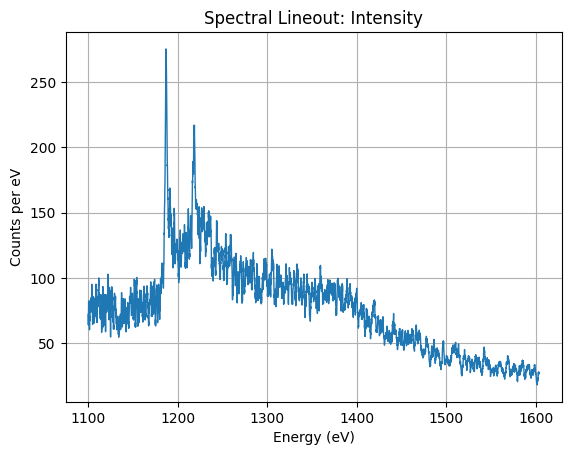

In [6]:
#WARNING: If this cell does not work, you may need to run the parabolic fit again (2 cells above). It should not be necessary, but it happened once to me.
#It's an error wit the energy binning. Can just be ignored but it's annoying



'''
Spectral lineout, combining SPC with Bragg mapping. 
Below we define 3 funcitons of summing along the conic sections, one for each type of conic. We sum along the iso energy contours, 
and uses the centre as the coord reference point along with the semi major
and minor axes. 

'''

#Define the eV sampling step here, note that 0.1was used in the paper, but this takes a while to run. I recommend 1 for a quick test

#The tolerance is also set to 2, but you can change this at your discretion.
step_e=0.1


def sum_along_ellipse_by_row(grid, center, a, b, tolerance=3):
    '''sum along elliptical curves, outputs total within lateral tolerance'''
    h, k = center
    total = 0.0
    y_min = 0
    y_max = 2000
    
    for y in range(y_min, y_max+1):
        u = (y - k) / b
        if abs(u) > 1:
            continue
        x_float = h - a * np.sqrt(1 - u**2)
        xi = int(round(x_float))
        if 0 <= y < grid.shape[0]:
            x_start = max(0, xi - tolerance)
            x_end   = min(grid.shape[1], xi + tolerance + 1)
            total += grid[y, x_start:x_end].sum()
    return total

def sum_along_hyperbola_by_row(grid, center, a, b, tolerance=2, branch='positive'):
    '''sum along hyperbolic curves, outputs total within lateral tolerance'''
    h, k = center
    total = 0.0
    for y in range(grid.shape[0]):
        ratio = (y - k) / b

        #the branch depends if it's summing the negative or positive branch. 
        #In the case for our setup, it's almost always the positive
        if branch == 'positive':
            x_float = h + a * np.sqrt(1 + ratio**2)
            xi = int(round(x_float))
            if 0 <= y < grid.shape[0]:
                x_start = max(0, xi - tolerance)
                x_end   = min(grid.shape[1], xi + tolerance + 1)
                total += grid[y, x_start:x_end].sum()
        elif branch == 'negative':
            x_float = h - a * np.sqrt(1 + ratio**2)
            xi = int(round(x_float))
            if 0 <= y < grid.shape[0]:
                x_start = max(0, xi - tolerance)
                x_end   = min(grid.shape[1], xi + tolerance + 1)
                total += grid[y, x_start:x_end].sum()
        
        
    return total

def sum_along_parabola_with_tolerance(grid, vertex, a, x_min, x_max, tolerance=0, num_points=1000):
    '''sum along parabolic curves, outputs total within lateral tolerance'''
    h, k = vertex
    x_values = np.linspace(x_min, x_max, num_points)
    y_values = a * (x_values - h)**2 + k
    ix = np.round(x_values).astype(int)
    iy = np.round(y_values).astype(int)
    total = 0.0
    for xi, yi in zip(ix, iy):
        if 0 <= yi < grid.shape[0]:
            x_start = max(0, xi - tolerance)
            x_end   = min(grid.shape[1], xi + tolerance + 1)
            total  += grid[yi, x_start:x_end].sum()
    return total




def sum_along_conic(grid, alpha, d, theta_z_opt, theta_y, theta_x, C1_opt, b_opt, shift_part_1, 
    tolerance=2, num_points=3000, x_min=0, x_max=2000):
    '''total sum along conic sections, outputs total within lateral tolerance It;s a combinaiton of above '''

    #Use conic param with shift to get the conic type and parameters
    result = isoenergy_curves(np.deg2rad(alpha), d, theta_z_opt, theta_y, theta_x, C1_opt, b_opt, shift_part_1)
    conic_type = result.get("type", "").lower()
    
    if conic_type == "ellipse":
        center = result["center_shifted"]
        a_axis, b_axis = result["semi_axes"]
        return sum_along_ellipse_by_row(grid, center, a_axis, b_axis, tolerance)
    
    elif conic_type == "hyperbola":
        center = result["center_shifted"]
        a_axis, b_axis = result["semi_axes"]
        return sum_along_hyperbola_by_row(grid, center, a_axis, b_axis, tolerance, branch='positive')
    
    elif conic_type == "parabola":
        vertex = result.get("vertex_shifted", result.get("vertex"))
        focal_length = result["focal_length"]
       
        a_coeff      = 1/(4*focal_length)   #Defined in paper
        return sum_along_parabola_with_tolerance(grid, vertex, a_coeff, x_min, x_max, tolerance=tolerance, num_points=num_points)
   


two_d_crystal=15.96

def energy_from_half_angle(alpha):
    
    lam = two_d_crystal * np.cos(alpha)
    # Energy (in eV): E = (12398 eV*A)/lambda
    return 12398 / lam



#grid = np.where(scrubbed_image_array[8] != 0, 1, 0)
grid=photon_map_all[1]

d = d_opt
theta_z_opt=theta_z_opt 
theta_y = 0
theta_x = 0





def alpha_from_energy(E):
    # Returns alpha in radians.
    return np.arccos(12398 / (two_d_crystal* E))


#alpha_values = np.arange(45, 61, 0.04)
sum_values= []

tol=2  #Lateral pixeltolerance

#Energy range and step

#Define energy range (eV)
E_min, E_max = 1100, 1604
energies=np.arange(E_min, E_max, step_e)


#Loop over the range of alphas, compute the sum along the conic for each, and store the result.
for E in energies:
    #Convert half-angle values to energy values.
    #Note: energy_from_half_angle expects angles in radians.
    alpha_rad = alpha_from_energy(E)
    alpha_deg = np.rad2deg(alpha_rad)
    N = sum_along_conic(grid, alpha_deg, d_opt, theta_z_opt, theta_y, theta_x, C1_opt, b_opt, shift_part_1, tolerance=tol)
    sum_values.append(N)
sums = np.array(sum_values)


#For the energy binin g to get the vertex locations

theta_X=theta_y=0

def get_x_vertex_from_alpha(alpha_rad, d, theta_z, theta_y, theta_x, C1, b, shift):
    res = isoenergy_curves(alpha_rad, d, theta_z, theta_y, theta_x, C1, b, shift)
    return res['vertex_shifted'][0]


windows = []
last_dx = None #for the case of no vertex difference. This does rarely happen for the parabolic case, so we just ingore it since only one bin
dx_min = 0.1  #minimum dx

for E in energies:
    # Convert energies to half-angles (rad) for E and E+delta_E
    
    a0 = alpha_from_energy(E)
    #print(a0)
    a1 = alpha_from_energy(E + step_e)

    # Vertex x for each
    res0 = isoenergy_curves(a0, d_opt, theta_z_opt, theta_y, theta_x, C1_opt, b_opt, shift_part_1)
    
    x0=res0['vertex_shifted'][0]
  
    
    res1 = isoenergy_curves(a1, d_opt, theta_z_opt, theta_y, theta_x, C1_opt, b_opt, shift_part_1)
    x1=res1['vertex_shifted'][0]
  
    




    dx = x1 - x0

    #if dx is effectively zero (parabola), reuse last
    if abs(dx) < dx_min:
        if last_dx is None:
            dx = dx_min
        else:
            dx = last_dx
    else:
        last_dx = dx

    # eV per pixel, note the negativeas inverse
    differential = abs(step_e / dx)

    #total window width in eV
    w = (2*tol + 1) * differential
    windows.append(w)
    
    #print(W)
Ws = np.array(windows)


# Compute intensity normalized to counts per eV
intensity = sums/windows

# Plot
plt.figure()
plt.plot(energies, intensity, '-', linewidth=1)
plt.xlabel('Energy (eV)')
plt.ylabel('Counts per eV')
plt.title('Spectral Lineout: Intensity')
plt.grid(True)
#plt.yscale('log')
plt.show()

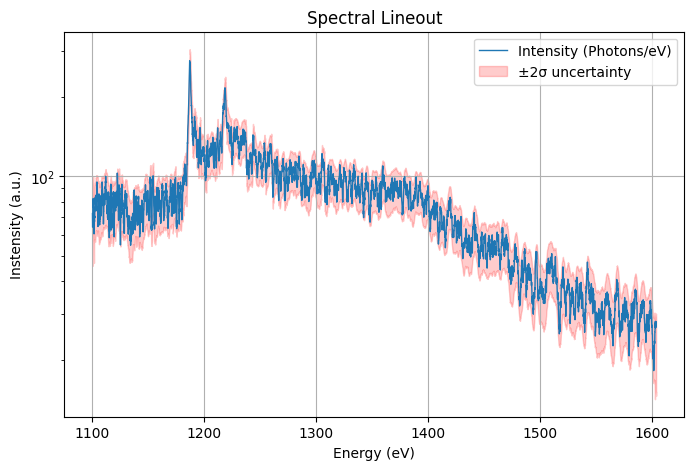

In [7]:
#Above with Wiener filtering
intensity_photons_per_eV = sums / Ws



#Poisson uncertainties on raw sums
sigma_sums = np.sqrt(sums)

#Propagate to counts per eV uncertainty
sigma_photons_per_eV = sigma_sums / Ws



#Wiener filtering with window size of 2eV (FWHM) which is roughly 30 pixes
smoothed_intensity = wiener(intensity_photons_per_eV, mysize=30)

#Define plus minus 2 sigma error bands
upper= smoothed_intensity+2*sigma_photons_per_eV
lower = smoothed_intensity-2*sigma_photons_per_eV

#Plot with Wiener
plt.figure(figsize=(8, 5))
plt.plot(energies, intensity_photons_per_eV, '-', linewidth=1, label='Intensity (Photons/eV)')
plt.fill_between(energies, lower, upper, color='red', alpha=0.2, label='±2σ uncertainty')
plt.xlabel('Energy (eV)')
plt.ylabel('Instensity (a.u.)')
plt.title('Spectral Lineout')
plt.grid(True)
plt.legend()
plt.yscale('log')
#plt.ylim(1e1,0.5*1e3)
plt.savefig('wiener_1.svg', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
#SNR and FWHM part for the dame image above



#Window size of around 2 eV, the FWHM of the 1188eV peak (see paper)
half_window = 30
smooth_hw   = 30

#Baseline correction to correct for the continuous spectrum
#
baseline_mor, params = morphological.mor(
    intensity,
    half_window=half_window,
    smooth_half_window=smooth_hw)
corrected_intensity = intensity - baseline_mor





#Gaussian to fit on oeak of graph
def gaussian(x, A, mu, sigma, C):
    return A * np.exp(-0.5 * ((x - mu)/sigma)**2) + C

fit_mask = (energies > 1180) & (energies < 1196)
x_fit = energies[fit_mask]
y_fit = corrected_intensity[fit_mask]
initial_guess = [
    max(y_fit) - np.median(y_fit),  #A
    1188,                           #mu
    2.0,                            #sigma
    np.median(y_fit)]                  #C


#fitting the Gaussian
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
A, mu, sigma, C = popt
FWHM = 2.355 * sigma

print(f"Fitted mu= {mu:.3f} eV, sigma= {sigma:.3f} eV, FWHM = {FWHM:.3f}eV")
print(f"A = {A:.1f}, offset C = {C:.1f}")

#the gauss lim is where the gaussian is cut off, so we can use this to get the background level and noise
gauss_lim = 1.5
bg_mask = (energies < (mu - gauss_lim*FWHM)) | (energies > (mu + gauss_lim*FWHM))
background_vals = corrected_intensity[bg_mask]
background_level = np.median(background_vals)
noise= np.std(background_vals)
peak_signal = A + C
SNR= (peak_signal - background_level) / noise

print(f"Background level:",background_level)
print(f"Noise (σ_bg):",noise)
print(f"Peak signal:", peak_signal)
print(f"SNR=",SNR)




Fitted mu= 1187.030 eV, sigma= 0.855 eV, FWHM = 2.013eV
A = 136.3, offset C = 14.4
Background level: 9.317457247141645
Noise (σ_bg): 9.257367919812845
Peak signal: 150.66563142687082
SNR= 15.268721671654895
